In [1]:
import pandas as pd
import sklearn
import numpy as np

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, v_measure_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning

from sklearn import tree, naive_bayes
from sklearn.utils._testing import ignore_warnings

In [3]:
sklearn.__version__

'0.24.2'

# Предобработка данных

## Загрузка данных

### Классификация

In [4]:
df = pd.read_csv('../data/bank_additional_preprocessed.csv', sep=';')

In [5]:
df

,age,campaign,pdays,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,...,poutcome_nonexistent,poutcome_success,previous_0,previous_1,previous_2,previous_3,previous_4,previous_5,previous_6,previous_7
0,56,1,999,1.1,93.994,-36.4,4.857,5191.0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,57,1,999,1.1,93.994,-36.4,4.857,5191.0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,37,1,999,1.1,93.994,-36.4,4.857,5191.0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,40,1,999,1.1,93.994,-36.4,4.857,5191.0,0,1,...,1,0,1,0,0,0,0,0,0,0
4,56,1,999,1.1,93.994,-36.4,4.857,5191.0,0,0,...,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,1,999,-1.1,94.767,-50.8,1.028,4963.6,1,0,...,1,0,1,0,0,0,0,0,0,0
41184,46,1,999,-1.1,94.767,-50.8,1.028,4963.6,0,0,...,1,0,1,0,0,0,0,0,0,0
41185,56,2,999,-1.1,94.767,-50.8,1.028,4963.6,0,0,...,1,0,1,0,0,0,0,0,0,0
41186,44,1,999,-1.1,94.767,-50.8,1.028,4963.6,1,0,...,1,0,1,0,0,0,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 70 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   campaign                       41188 non-null  int64  
 2   pdays                          41188 non-null  int64  
 3   emp.var.rate                   41188 non-null  float64
 4   cons.price.idx                 41188 non-null  float64
 5   cons.conf.idx                  41188 non-null  float64
 6   euribor3m                      41188 non-null  float64
 7   nr.employed                    41188 non-null  float64
 8   y                              41188 non-null  int64  
 9   job_admin.                     41188 non-null  int64  
 10  job_blue-collar                41188 non-null  int64  
 11  job_entrepreneur               41188 non-null  int64  
 12  job_housemaid                  41188 non-null 

Посмотрим на сбалансированность признаков.

In [7]:
labels, samples = np.unique(df.y, return_counts=True)
labels, samples

(array([0, 1], dtype=int64), array([36548,  4640], dtype=int64))

Как мы видим, данные несбалансированы: данных класса 0 приблизительно в 10 раз больше, чем данных класса 1.

При таком дисбалансе при downsampling потеряется большое число информации, поэтому выполним upsampling.

Для того, чтобы данные из обучающей выборки не попали в тестовую, выполним разбиение на обучение и тест

In [8]:
def upsample(df_big, df_small, verbose=False):
    if verbose:
        print('Upsample from {} to {}'.format(len(df_small), len(df_big)))
    df_small_copy = df_small.copy()
    i = len(df_small)
    while i < len(df_big):
        if verbose:
            print('GET i: {}'.format(i))
        if i + len(df_small_copy) < len(df_big):
            df_small = df_small.append(df_small_copy)
            i += len(df_small_copy)
        else:
            df_small = df_small.append(df_small_copy.loc[np.random.permutation(len(df_small_copy))].loc[i % len(df_small_copy) : (len(df_big) - 1) % len(df_small_copy)])
            i = len(df_small)
    return df_small

In [9]:
def downsample(df_big, df_small, verbose=False):
    if verbose:
        print('Downsample from {} to {}'.format(len(df_big), len(df_small)))
    return df_big.loc[np.random.permutation(len(df_big))[:len(df_small)]]

In [10]:
'''
# Upsample
df_0 = df.loc[df.y == 0].reset_index(drop=True)
df_0_train, df_0_test = train_test_split(df_0, test_size=0.2)

df_1 = df.loc[df.y == 1].reset_index(drop=True)
df_1_train, df_1_test = train_test_split(df_1, test_size=0.2)

df_0_train = df_0_train.reset_index(drop=True)
df_1_train = df_1_train.reset_index(drop=True)

df_0_test = df_0_test.reset_index(drop=True)
df_1_test = df_1_test.reset_index(drop=True)

df_1_train_up = upsample(df_0_train, df_1_train, verbose=True)
df_1_test_up = upsample(df_0_test, df_1_test, verbose=True)

df_train = pd.concat([df_0_train, df_1_train_up], ignore_index=True)
df_train = df_train.loc[np.random.permutation(len(df_train))]
df_test = pd.concat([df_0_test, df_1_test_up], ignore_index=True)
df_test = df_test.loc[np.random.permutation(len(df_test))]

df_sample = pd.concat([df_train, df_test], ignore_index=True)
print(df_train.shape, df_train[df_train.y == 0].shape, df_train[df_train.y == 1].shape)
'''
# Downsample
# num_obj = 1000
df_0 = df.loc[df.y == 0].reset_index(drop=True)
df_1 = df.loc[df.y == 1].reset_index(drop=True)
# df_1 = df_1.loc[np.random.permutation(len(df_1))[:num_obj]]
df_0 = downsample(df_0, df_1, verbose=True)

df_sample = pd.concat([df_0, df_1], ignore_index=True)

Downsample from 36548 to 4640


In [11]:
X = df_sample.drop(['y'], axis=1)
y = df_sample.y
X.shape, y.shape

((9280, 69), (9280,))

Для удобства обработки разделим признаки на категориальные и вещественные

In [12]:
numeric_cols = np.array(['age', 'campaign', 'pdays', 'emp.var.rate', 'cons.price.idx', 
           'cons.conf.idx', 'euribor3m', 'nr.employed'])
X_numeric = X[numeric_cols]

In [13]:
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))
X_categorical = X[categorical_cols]
for col in categorical_cols:
    X_categorical[col] = X_categorical[col].astype('string')

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [14]:
print(X_categorical.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9280 entries, 0 to 9279
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   month_jul                      9280 non-null   string
 1   poutcome_nonexistent           9280 non-null   string
 2   job_self-employed              9280 non-null   string
 3   job_management                 9280 non-null   string
 4   education_basic.6y             9280 non-null   string
 5   job_services                   9280 non-null   string
 6   contact_telephone              9280 non-null   string
 7   job_retired                    9280 non-null   string
 8   marital_single                 9280 non-null   string
 9   education_illiterate           9280 non-null   string
 10  housing_unknown                9280 non-null   string
 11  education_basic.4y             9280 non-null   string
 12  month_may                      9280 non-null   string
 13  def

Разделим данные на обучение и тест

In [15]:
X_train, X_test, X_train_cat, X_test_cat, X_train_num, X_test_num, y_train, y_test = train_test_split(X, X_categorical, X_numeric, y, test_size=0.2)

Нормализируем значения

In [16]:
scaler = StandardScaler()
scaler.fit(X_numeric)

X_train_num_sc = scaler.transform(X_train_num)
X_test_num_sc = scaler.transform(X_test_num)
X_num_sc = scaler.transform(X_numeric)

Соединяем воедино все значения

In [17]:
X_train_transform = np.hstack((X_train_num_sc, X_train_cat))
X_test_transform = np.hstack((X_test_num_sc, X_test_cat))
X_transform = np.hstack((X_num_sc, X_categorical))

Для некоторых алгоритмов введено условие неотрицательности, реализуем его

# Обучение модели

Напишем методы, которые будут обучать модель и предсказывать результат

Данный метод будет выводить на печать метрики в задаче [классификации](https://scikit-learn.org/0.20/modules/classes.html#classification-metrics) и [кластеризации](https://scikit-learn.org/0.20/modules/classes.html#clustering-metrics).

In [18]:
def print_metrics(X, y_true, y_pred, type_task='classification'):
    if type_task == 'classification':
        print('Confusion matrix:')
        print(confusion_matrix(y_true, y_pred))
        print('Classification report:')
        print(classification_report(y_true, y_pred))
    elif type_task == 'clustering':
        print('Silhouette score:')
        print(silhouette_score(X, y_pred))
        print('V measure score:')
        print(v_measure_score(y_true, y_pred))

Функция обучения модели и предсказывания значений

In [19]:
def fit_predict(X_train, X_test, y_train, y_test, type_task='classification', 
                model=tree.DecisionTreeClassifier, init_parameters={}, custom_predict=None,
                use_test=True, 
                verbose=False, draw=False, **parameters):
    
    if not use_test:
        X_test = X_train
        y_test = y_train
    if custom_predict:
        X_test, y_test, y_pred = custom_predict(X_train, X_test, y_train, y_test, type_task, model, init_parameters, verbose=verbose, draw=draw, **parameters)
    elif type_task == 'classification':
        print('Start fit model and predict values')
        classifier_model = model(**init_parameters)
        clf_model = GridSearchCV(classifier_model, parameters)
        clf_model.fit(X_train, y_train)
        # Get best model
        best_est = clf_model.best_estimator_
        if verbose:
            print('GridSearchCV: best estimator:\n{},\nwith best parameters:\n{}'.format(clf_model.best_estimator_, clf_model.best_params_))
        # Predict value
        y_pred = best_est.predict(X_test)
    elif type_task == 'clustering':
        print('Start fit model and predict values')
        classifier_model = model(**init_parameters)
        classifier_model.fit(X_train)
        # Обучаем модель
        y_pred = classifier_model.predict(X_test)
    
    if verbose:
        print_metrics(X_test, y_test, y_pred, type_task=type_task)
    if draw:
        if(X_test.shape[1] == 2):
            plot_2d(X_test[:, 0], X_test[:, 1], y_pred)
        elif(X_test.shape[1] == 3):
            plot_3d(X_test[:, 0], X_test[:, 1], X_test[:, 2], y_pred)
        else:
            while X_test.shape[1] < 3:
                print('Add useless zeros dimension to dataset')
                X_test = np.hstack((X_test, np.zeros((X_test.shape[0], 1))))
            pca = PCA(n_components=3)
            pca_3d = pca.fit_transform(X_test, y_test)

            x = pca_3d[:, 0]
            y = pca_3d[:, 1]
            z = pca_3d[:, 2]

            plot_3d(x, y, z, y_pred)

Данная функция печатает метки для различных значений отбора признаков

In [20]:
@ignore_warnings(category=ConvergenceWarning)
def print_with_selection_features(model=tree.DecisionTreeClassifier, init_parameters={}, custom_fit_predict=None, **parameters):
    if custom_fit_predict:
        fit_predict = custom_fit_predict
    %time fit_predict(X_train_transform, X_test_transform, y_train, y_test, model=model, init_parameters=init_parameters, **parameters)

## Задание:
1. Реализовать недостающие фрагменты
2. Получить параметры распределений для красных и синих точек
3. К красным и синим точкам добавить зеленые. Удалите информацию о цветах. Найдите параметры распределения для красных, синих и зеленых точек.

---

EM-алгоритм -- это не какой-то конкретный алгоритм, это целый класс алгоритмов. Поэтому можете использовать другую вариацию.

Если готовы пойти дальше, то попробуйте применить данную технику для кластеризации ваших данных.



Предположим, что нам даны два набора наблюдейний, красные и синие точки, которые описываются двумя разными [нормальными распределениями](https://en.wikipedia.org/wiki/Normal_distribution). Наша цель - найти среднее и стандартное отклонение для каждого набора точек.

In [21]:
# генерация наблюдений
import numpy as np

np.random.seed(42)

red_mean = 40
red_std = 20

blue_mean = 80
blue_std = 13

red = np.random.normal(red_mean, red_std, size=40)
blue = np.random.normal(blue_mean, blue_std, size=40)

both_colours = np.sort(np.concatenate((red, blue)))

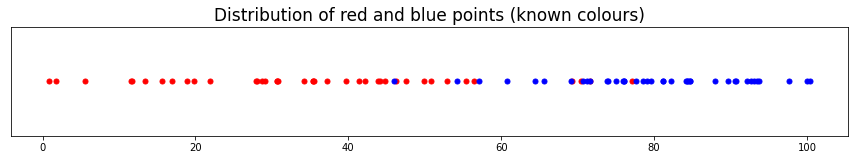

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 2)

plt.plot(red, np.zeros_like(red), '.', color='r', markersize=10);
plt.plot(blue, np.zeros_like(blue), '.', color='b', markersize=10);
plt.title(r'Distribution of red and blue points (known colours)', fontsize=17);
plt.yticks([]);

In [23]:
print(np.mean(red), np.std(red))
print(np.mean(blue), np.std(blue))

35.62726323164121 18.816469710458275
79.62243495704179 12.384211983757545


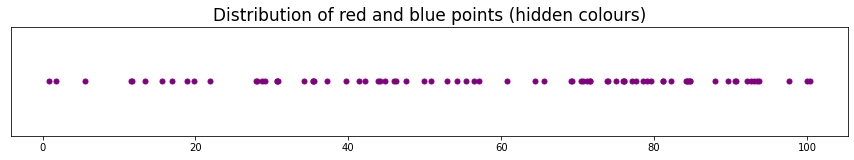

In [24]:
plt.rcParams['figure.figsize'] = (15, 2)

plt.plot(both_colours, np.zeros_like(both_colours), '.', color='purple', markersize=10);
plt.title(r'Distribution of red and blue points (hidden colours)', fontsize=17);
plt.yticks([]);

Теперь у нас появились скрытые переменные.

Мы знаем, что каждая точка на самом деле либо красная, либо синяя, но реальный цвет нам неизвестен. Таким образом, мы не знаем, как определить характеристики каждого распределения.

Как мы можем теперь оценить наиболее вероятные значения среднего и стандартного отклонения каждой группы?

Мы будем использовать **Expectation Maximisation**, чтобы найти наилучшие оценки для этих значений.

## Функция правдоподобия

Для начала нам нужна [функция правдоподобия](https://en.wikipedia.org/wiki/Likelihood_function). 
Максимизация ожидания заключается в нахождении параметров, при которых значения этой функции принимают как можно большие значения с учетом наших данных.

Нас интересует вероятность того, что параметры распределения, например, среднее и стандартное отклонение синих точек (обозначаем как $ B $), верны с учетом наблюдаемых данных (обозначенных $ x_i $). Это можно обозначить следующим образом:

$$p(B \mid x_i)$$

[Вспомним теорему Байеса](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$ p(B \mid x_i) = \frac{p(x_i \mid B)\cdot p(B)}{p(x_i)}$$

Отбросим вероятности каждого класса, так как считаем (а в нашем случае и знаем), что они равновероятны. Также отбросим константы, которые укладывают значения между 0 и 1.

Получится следующая функция правдоподобия, именно её и нужно максимизировать:

$$L(B \mid x_i) =  P(x_i \mid B)$$

Как посчитать вероятность на основе функции плотности вы прекрасно знаете. Для нормального распределения можно воспользоваться библиотечной функцией: 

``` python
stats.norm(mean, standard_deviation).pdf(x)
```

## Максимизация ожиданий

Мы знаем, что у нас есть две группы наблюдений, каждая из которых подчиняется нормальному распределению. У нас также есть функция правдоподобия, и мы хотели бы найти значения для среднего и стандартного отклонения, при которых значения функции правдоподобия становятся максимальными.

Наш подход будет следующим:


1. Начнинаем с первоначальных оценок среднего и стандартного отклонения для красной и синей групп (могут быть любыми).
2. С помощью функции правдоподобия проверяем правдоподобность оценки среднего и стандартного отклонения на группах точек.
3. Произведём взвешивание для каждых параметров (среднее значение, отклонение стенда) для каждой точки из данных. Другими словами, чем больше вес, тем больше мы считаем, что точка была получена из распределения с этими параметрами. Эти веса позволят нам «перемасштабировать» точки данных вдоль оси (шаг **Expectation**).
4. Вычисляем новые оценки максимального правдоподобия каждого параметра на основе масштабированных точек данных (шаг **Maximisation**).
5. Повторяем шаги 2–4 до тех пор, пока оценка каждого параметра не сойдется или не будет достигнуто заданное количество итераций.

Функция для вычисления веса для каждой точки данных (параметры и значения являются NumPy массивами):

In [25]:
def weight_of_colour(colour_likelihood, total_likelihood):
    return colour_likelihood / total_likelihood

Функции для вычисления нового среднего и стандартного отклонения с использованием весов:

estimate_mean(data, weight)$=\frac{\sum(data_i \times weight_i)}{\sum weight_i}$


estimate_std(data, weight, mean)$=\sqrt\frac{\sum(weight_i *(data_i - mean)^2)}{\sum weight_i}$

In [26]:
def estimate_mean(data, weight):
    return np.sum(data * weight) / np.sum(weight)

def estimate_std(data, weight, mean):
    return np.sqrt(np.sum(weight * np.power(data - mean, 2)) / np.sum(weight))

У нас нет информации о параметрах распределений, поэтому просто делаем предположения:

In [27]:
# Для среднего
red_mean_guess = 35
blue_mean_guess = 90

# Для стандартного отклонения
red_std_guess = 20
blue_std_guess = 20

И опишем функцию для отображения данных и распределений

In [28]:
from scipy import stats


def plot_guesses(red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess, alpha=1):
    plt.rcParams['figure.figsize'] = (15, 5)
    plt.plot(both_colours, np.zeros_like(both_colours), '.', color='purple', markersize=10)

    lo = np.floor(both_colours.min()) - 1
    hi = np.ceil(both_colours.max()) + 1
    x = np.linspace(lo, hi, 500)
    
    plt.plot(x, stats.norm(red_mean_guess, red_std_guess).pdf(x), color='r', alpha=alpha)
    plt.plot(x, stats.norm(blue_mean_guess, blue_std_guess).pdf(x), color='b', alpha=alpha)
    
    r_height = stats.norm(red_mean_guess, red_std_guess).pdf(red_mean_guess)
    b_height = stats.norm(blue_mean_guess, blue_std_guess).pdf(blue_mean_guess)
    
    plt.vlines(red_mean_guess, 0, r_height, 'r', '--', alpha=alpha)
    plt.vlines(blue_mean_guess, 0, b_height, 'b', '--', alpha=alpha)

Давайте отрисуем наши предположения:

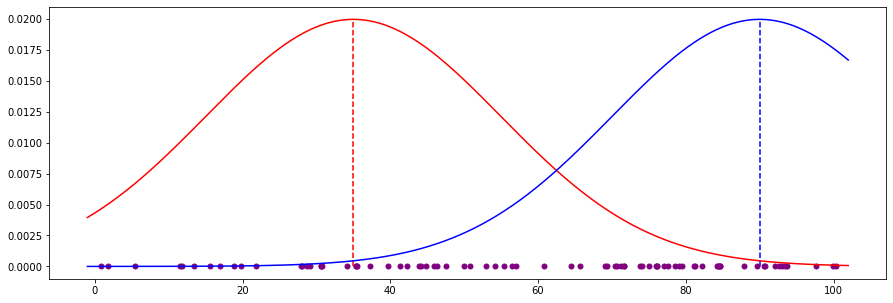

In [29]:
plot_guesses(red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess)

Они далековаты от истины, поэтому запускаем EM алгоритм:

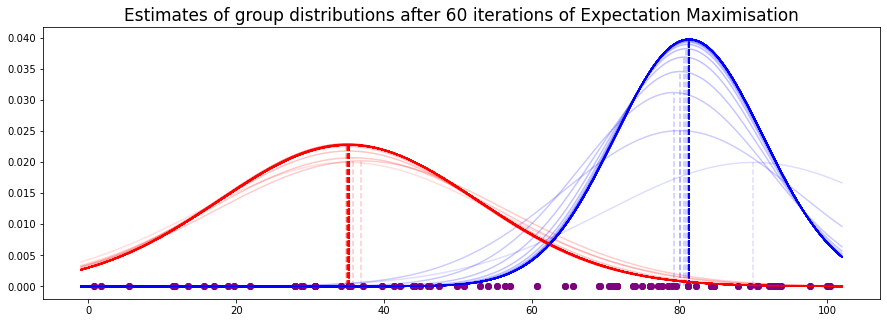

In [30]:
# estimates for the mean
red_mean_guess = 35
blue_mean_guess = 90

# estimates for the standard deviation
red_std_guess = 20
blue_std_guess = 20

N_ITER = 60 # number of iterations of EM
alphas = np.linspace(0.2, 1, N_ITER) # transparency of curves to plot for each iteration


# plot initial estimates
plot_guesses(red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess, alpha=0.13)


for i in range(N_ITER):
    
    ## Expectation step
    ## ----------------

    likelihood_of_red = stats.norm(red_mean_guess, red_std_guess).pdf(both_colours) # правдоподобие для красных 
    likelihood_of_blue = stats.norm(blue_mean_guess, blue_std_guess).pdf(both_colours) # правдоподобие для синих

    total_likelihood = likelihood_of_red + likelihood_of_blue
    
    red_weight = weight_of_colour(likelihood_of_red, total_likelihood) # weight_of_colour для красных
    blue_weight = weight_of_colour(likelihood_of_blue, total_likelihood) # weight_of_colour для синих

    ## Maximisation step
    ## -----------------
    
    red_std_guess = estimate_std(both_colours, red_weight, red_mean_guess) # пересчитать
    blue_std_guess = estimate_std(both_colours, blue_weight, blue_mean_guess) # пересчитать

    red_mean_guess = estimate_mean(both_colours, red_weight) # пересчитать
    blue_mean_guess = estimate_mean(both_colours, blue_weight) # пересчитать

    plot_guesses(red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess, alpha=alphas[i])
    
plt.title(
    r'Estimates of group distributions after {} iterations of Expectation Maximisation'.format(
        N_ITER
    ), 
    fontsize=17);

Давайте сравним результаты с изначальными значениями:

In [31]:
from IPython.display import Markdown

md = """
|            | True Mean      | Estimated Mean | True Std.      | Estimated Std. | 
| :--------- |:--------------:| :------------: |:-------------: |:-------------: |
| Red        | {true_r_m:.5f} | {est_r_m:.5f}  | {true_r_s:.5f} | {est_r_s:.5f}  | 
| Blue       | {true_b_m:.5f} | {est_b_m:.5f}  | {true_b_s:.5f} | {est_b_s:.5f}  |
"""

Markdown(
    md.format(
        true_r_m=np.mean(red),
        true_b_m=np.mean(blue),
        
        est_r_m=red_mean_guess,
        est_b_m=blue_mean_guess,
        
        true_r_s=np.std(red),
        true_b_s=np.std(blue),
        
        est_r_s=red_std_guess,
        est_b_s=blue_std_guess,
    )
)


|            | True Mean      | Estimated Mean | True Std.      | Estimated Std. | 
| :--------- |:--------------:| :------------: |:-------------: |:-------------: |
| Red        | 35.62726 | 35.21838  | 18.81647 | 17.51718  | 
| Blue       | 79.62243 | 81.32034  | 12.38421 | 10.03677  |


### Для N нормальных распределений

In [53]:
N_DISTRIBUTIONS = 5
SIZE = 30
N_ITER = 20 # number of iterations of EM

In [54]:
def generate_distributions(n_distributions = 2, size = 40):
    means = np.random.randint(0, 250, size=n_distributions)
    stds = np.random.randint(5, 25, size=n_distributions)
    points = []
    for i in range(n_distributions):
        points.append(np.random.normal(means[i], stds[i], size=size))
    
    points = np.sort(np.concatenate(points))
    return means, stds, points

In [55]:
def plot_guesses(red_mean_guess, blue_mean_guess, red_std_guess, blue_std_guess, alpha=1):
    plt.rcParams['figure.figsize'] = (15, 5)
    plt.plot(both_colours, np.zeros_like(both_colours), '.', color='purple', markersize=10)

    lo = np.floor(both_colours.min()) - 1
    hi = np.ceil(both_colours.max()) + 1
    x = np.linspace(lo, hi, 500)
    
    plt.plot(x, stats.norm(red_mean_guess, red_std_guess).pdf(x), color='r', alpha=alpha)
    plt.plot(x, stats.norm(blue_mean_guess, blue_std_guess).pdf(x), color='b', alpha=alpha)
    
    r_height = stats.norm(red_mean_guess, red_std_guess).pdf(red_mean_guess)
    b_height = stats.norm(blue_mean_guess, blue_std_guess).pdf(blue_mean_guess)
    
    plt.vlines(red_mean_guess, 0, r_height, 'r', '--', alpha=alpha)
    plt.vlines(blue_mean_guess, 0, b_height, 'b', '--', alpha=alpha)

In [56]:
def plot_guesses(means, stds, points, colors=None, alpha=1):
    plt.rcParams['figure.figsize'] = (15, 5)
    plt.plot(points, np.zeros_like(points), '.', color='purple', markersize=10)

    lo = np.floor(points.min()) - 1
    hi = np.ceil(points.max()) + 1
    x = np.linspace(lo, hi, 500)
    
    if colors is None:
        colors = ['r' for i in range(means.shape[0])]
        
    for i in range(means.shape[0]):
        plt.plot(x, stats.norm(means[i], stds[i]).pdf(x), color=colors[i], alpha=alpha)
        height = stats.norm(means[i], stds[i]).pdf(means[i])
        plt.vlines(means[i], 0, height, colors[i], '--', alpha=alpha)

[ 97 104  98 128 148] [20 10 21  9  9]


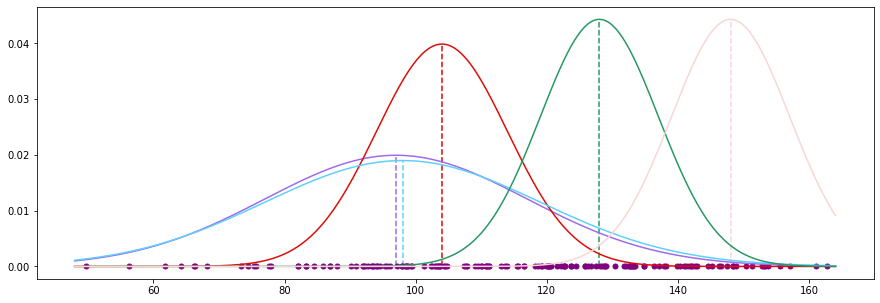

In [57]:
colors = np.random.random(size=(N_DISTRIBUTIONS, 3))
means, stds, points = generate_distributions(n_distributions=N_DISTRIBUTIONS, size=SIZE)
plot_guesses(means, stds, points, colors=colors)
print(means, stds)

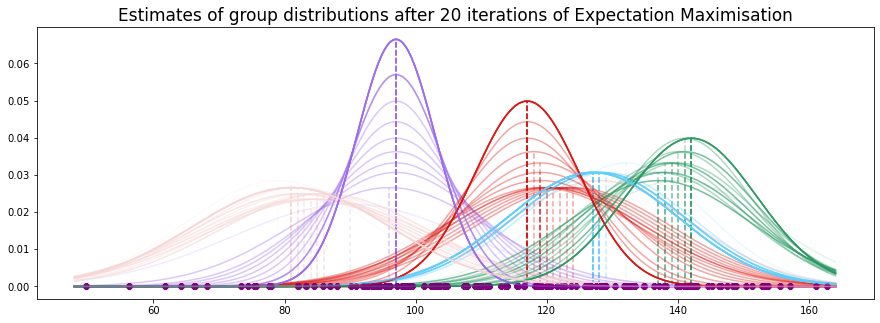

In [58]:
STD_MAX = 20
STD_MIN = 10
# estimates for the mean
means_pred = np.random.randint(points.min() + STD_MAX , points.max() - STD_MAX, size=N_DISTRIBUTIONS)

# estimates for the standard deviation
stds_pred = np.random.randint(STD_MIN, STD_MAX, size=N_DISTRIBUTIONS)

alphas = np.linspace(0.2, 1, N_ITER) # transparency of curves to plot for each iteration

# plot initial estimates
plot_guesses(means_pred, stds_pred, points, colors=colors, alpha=0.13)

for i in range(N_ITER):
    
    ## Expectation step
    ## ----------------
    likelihoods = np.zeros((N_DISTRIBUTIONS, *points.shape))
    for i in range(N_DISTRIBUTIONS):
        likelihoods[i] = stats.norm(means_pred[i], stds_pred[i]).pdf(points) # правдоподобие

    total_likelihood = np.sum(likelihoods, axis=0)
    
    weights = []
    for i in range(N_DISTRIBUTIONS):
        weights.append(weight_of_colour(likelihoods[i], total_likelihood)) # weight_of_colour

    ## Maximisation step
    ## -----------------
    
    for i in range(N_DISTRIBUTIONS):
        stds_pred[i] = estimate_std(points, weights[i], means_pred[i]) # пересчитать
        means_pred[i] = estimate_mean(points, weights[i]) # пересчитать

    plot_guesses(means_pred, stds_pred, points, colors=colors, alpha=alphas[i])
    
plt.title(
    r'Estimates of group distributions after {} iterations of Expectation Maximisation'.format(
        N_ITER
    ), 
    fontsize=17);

In [59]:
print("Means:")
print(means, means_pred)
print("Stds:")
print(stds, stds_pred)

Means:
[ 97 104  98 128 148] [ 97 117 127 142  81]
Stds:
[20 10 21  9  9] [ 6  8 13 10 15]


# Вывод

В данной работе мы реализовали алгоритм Наивного Байесса.